## Imports

In [72]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import pandas as pd
from scipy.optimize import curve_fit

C:\Users\17135\AppData\Local\Temp\ipykernel_46712\3447420317.py:5: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy.optimize import curve_fit


Questions
- Formula for Mstar
- Implementing Wolf formula - did I do it right?
- Properly fitting Hernquist profile

Data Table

In [100]:
def csv_to_dataframe(csv_file):
    csv_content = pd.read_csv(csv_file)
    df = pd.DataFrame(csv_content)
    return df

csv_file = 'table1A_20260110.csv'
df = csv_to_dataframe(csv_file)
#print(df_clean)

df_copy = df.copy()

sigma   = pd.to_numeric(df_copy.iloc[:, 13], errors="coerce")
serr_low = pd.to_numeric(df_copy.iloc[:, 14], errors="coerce")
serr_up = pd.to_numeric(df_copy.iloc[:, 15], errors="coerce")

to_drop = []

for idx in df_copy.index:
    s  = sigma.loc[idx]
    sl = serr_low.loc[idx]
    su = serr_up.loc[idx]

    if (s == -999 or sl == -999 or su == -999):
        to_drop.append(idx)

df_clean = df_copy.drop(index=to_drop).copy()
print("Dropped Rows:", len(to_drop), "Remaining Rows:", len(df_clean))
print(df_clean)

# if any entry in sigma or its error is -999, i want to delete the associated row entirely from the df
# could also delete anything that isnt G or GC in type but maybe not necessary given my loops and if statements

#df_clean = df.iloc[1:].copy()   # drop first row
#print(df_clean)

# ok I decided to get rid of any rows with sigma or serr_low or serr_up being -999
# I also will not consider serr_95 in my calculations for M_Err later since most values are -999

Dropped Rows: 18 Remaining Rows: 60
           Name  Name2          RA        Dec   Dist    MV   R_eff Type Phot  \
0   Aquarius II   Aqr2  338.481300  -9.327400  108.0  -4.4    5.10    G   LS   
2      Bootes I   Boo1  210.020035  14.513500   66.0  -6.0   10.50    G   LS   
3     Bootes II   Boo2  209.514130  12.855278   42.0  -2.9    3.07    G   LS   
4    Bootes III   Boo3  209.300000  26.800000   46.0  -5.8   30.00    G   LS   
5       ComaBer     CB  186.745422  23.906918   42.0  -4.3    5.67    G   LS   
7     Columba 1   Col1   82.856960 -28.042530  182.0  -4.2    2.20    G   LS   
8         CVn I   CVn1  202.009079  33.552082  220.0  -8.8    7.48    G   LS   
9        CVn II   CVn2  194.292664  34.322640  160.0  -5.2    1.52    G   LS   
10        Draco    Dra  260.068451  57.918472   81.5  -8.7    9.61    G   LS   
13   Eridanus 4   Eri4   76.438000  -9.515000   76.5  -3.8    3.24    G   LS   
14       Fornax    For   39.958336 -34.499721  142.5 -13.5   18.50    G   LS   
15  

## Problem 1 - Plot the velocity dispersion of (a) galaxies and (b) globular clusters as a function of R_eff

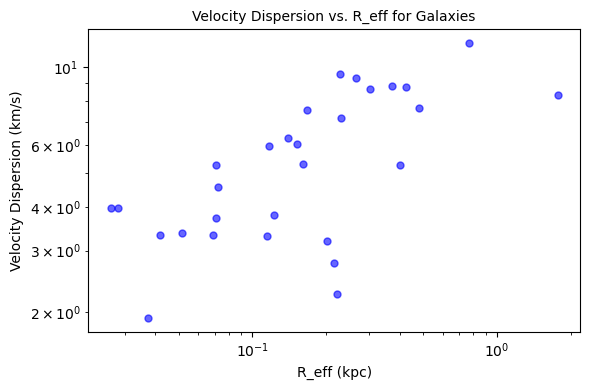

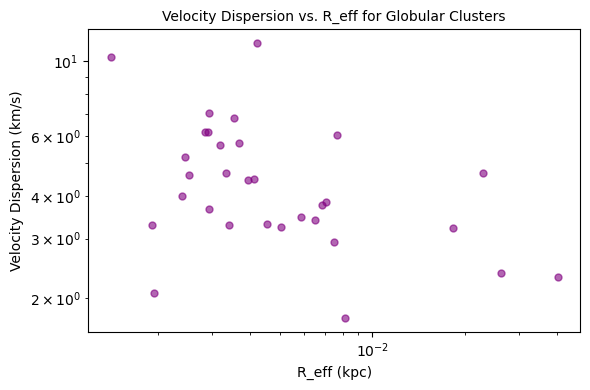

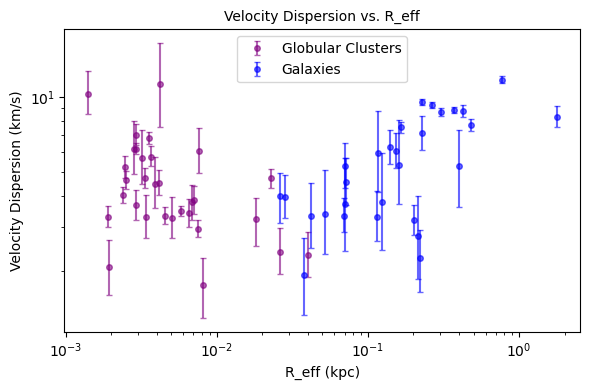

In [132]:
type_galactic_object = df_clean.iloc[:, 7].astype(str)
#print(len(type_galactic_object))

velocity_dispersion_g = []
reff_g = []
velocity_dispersion_gc = []
reff_gc = []

sigma = df_clean.iloc[:, 13].astype(float)
R_eff = df_clean.iloc[:, 6].astype(float)
distance = df_clean.iloc[:, 4].astype(float)

# realized I should just put R_eff in units of kpc instead of arcmin

sigmaerrlow = df_clean.iloc[:, 14].astype(float)
sigmaerrup = df_clean.iloc[:, 15].astype(float)

errlow_g = []
errhigh_g = []
errlow_gc = []
errhigh_gc = []

def arcmin_to_kpc(R_eff_i, distance_i):
    R_eff_kpc = distance_i * R_eff_i * np.pi / (180.0 * 60.0)
    return R_eff_kpc

for i, j in type_galactic_object.items():
    r = R_eff.loc[i]
    d = distance.loc[i]
    if j == 'G':
        velocity_dispersion_g.append(sigma.loc[i])
        reff_g.append(arcmin_to_kpc(r, d))
        errlow_g.append(sigmaerrlow.loc[i])
        errhigh_g.append(sigmaerrup.loc[i])
    elif j == 'GC':
        velocity_dispersion_gc.append(sigma.loc[i])
        reff_gc.append(arcmin_to_kpc(r, d))
        errlow_gc.append(sigmaerrlow.loc[i])
        errhigh_gc.append(sigmaerrup.loc[i])

plt.figure(figsize=(6,4))
plt.scatter(reff_g, velocity_dispersion_g, s=25, marker="o", alpha=0.6, c = "blue")
plt.xscale("log")
plt.yscale("log")

plt.xlabel('R_eff (kpc)', fontsize = 10)  
plt.ylabel('Velocity Dispersion (km/s)', fontsize = 10)  
plt.title('Velocity Dispersion vs. R_eff for Galaxies', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(reff_gc, velocity_dispersion_gc, s=25, marker="o", alpha=0.6, c = "purple")
plt.xscale("log")
plt.yscale("log")

plt.xlabel('R_eff (kpc)', fontsize = 10)  
plt.ylabel('Velocity Dispersion (km/s)', fontsize = 10)  
plt.title('Velocity Dispersion vs. R_eff for Globular Clusters', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()


# combined plots with error bars
plt.figure(figsize=(6,4))
#plt.scatter(reff_gc, velocity_dispersion_gc, s=25, marker="o", alpha=0.6, c = "purple", label="Globular Clusters")
#plt.scatter(reff_g, velocity_dispersion_g, s=25, marker="o", alpha=0.6, c = "blue", label="Galaxies")
plt.errorbar(reff_gc, velocity_dispersion_gc,
             yerr=np.vstack([errlow_gc, errhigh_gc]),
             fmt="o", ms=4, alpha=0.6, capsize=2, color="purple", ecolor="purple", label="Globular Clusters")
plt.errorbar(reff_g, velocity_dispersion_g,
             yerr=np.vstack([errlow_g, errhigh_g]),
             fmt="o", ms=4, alpha=0.6, capsize=2, color="blue", ecolor="blue", label="Galaxies")
plt.xscale("log")
plt.yscale("log")

plt.xlabel('R_eff (kpc)', fontsize = 10)  
plt.ylabel('Velocity Dispersion (km/s)', fontsize = 10)  
plt.title('Velocity Dispersion vs. R_eff', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.legend()
plt.show()

## Problem 2 - Using the Wolf et al. (2010) mass estimator we discussed in class, plot M_dyn vs r_1/2 for the same two samples. Include error bars on the mass and make sure to propagate errors on σ.

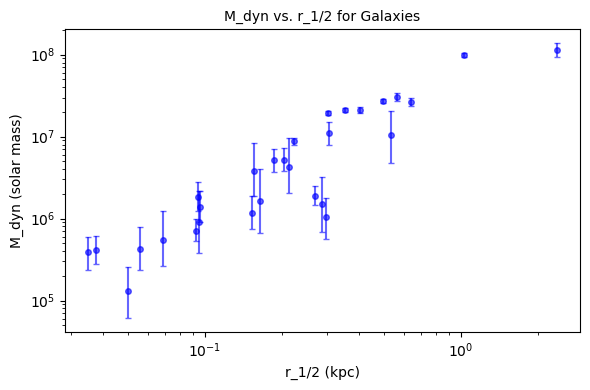

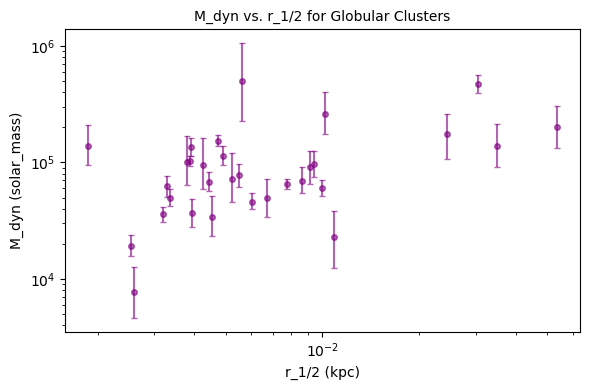

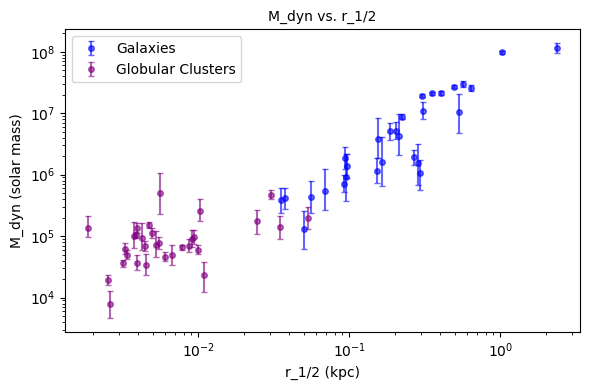

In [134]:
sigmaerrlow = df_clean.iloc[:, 14].astype(float)
sigmaerrup = df_clean.iloc[:, 15].astype(float)
distance = df_clean.iloc[:, 4].astype(float)

def calculate_M_dyn(sigma_i, R_eff_i, distance_i):
    # using Wolf et al. 2010 to calculate M_dyn
    # M_1/2 = 3/G <sigma> r_1/2 ~ 4/G <sigma> R_eff
    # sigma is in km/s
    # R_eff is in arcminutes
    # distance is in kpc

    G = 4.3009172706e-3  # units are pc * Msun^(-1) * (km/s)^2

    # small angle approximation using tan(R_eff_arcmin_to_radians/2) = R_eff_kpc/2distance 
    # 1 degree = 60 arcminutes and 360 degrees = 2pi radians

    R_eff_kpc = distance_i * R_eff_i * np.pi / (180.0 * 60.0)

    M_dyn = (4.0 / G) * (sigma_i**2) * R_eff_kpc * 1000 # convert the kpc to pc for consistency with G units

    return M_dyn

def error_M_dyn(sigma_i, R_eff_i, sigmaerrlow, sigmaerrup, distance_i):
 # find error associated with mass based on the error associated with sigma and error propagation
    M_dyn_local = calculate_M_dyn(sigma_i, R_eff_i, distance_i)

    sig_low  = sigma_i - sigmaerrlow # lower bound for velocity dispersion
    sig_high = sigma_i + sigmaerrup # upper bound for velocity dispersion

    M_low  = calculate_M_dyn(sig_low,  R_eff_i, distance_i) # lower bound for M_dyn
    M_high = calculate_M_dyn(sig_high, R_eff_i, distance_i) # upper bound for M_dyn

    errorM_low = M_dyn_local - M_low # M_dyn - lower bound
    errorM_high = M_high - M_dyn_local # upper bound - M_dyn 

    return M_dyn_local, errorM_low, errorM_high # correspond with serr_low and serr_up but for M_dyn
    
def reff_to_rhalf(R_eff_i, distance_i):
    R_eff_kpc = distance_i * R_eff_i * np.pi / (180.0 * 60.0)
    R_half = R_eff_kpc * (4.0 / 3.0)
    return R_half # units of kpc 

rhalf_g = []
M_g = []
rhalf_gc = []
M_gc = []
errMlow_g = []
errMhigh_g = []
errMlow_gc = []
errMhigh_gc = []


for i, j in type_galactic_object.items():
    s = sigma.loc[i]
    r = R_eff.loc[i]
    d = distance.loc[i]
    serrl = sigmaerrlow.loc[i]
    serrh = sigmaerrup.loc[i]
    _, errorM_low, errorM_high = error_M_dyn(s, r, serrl, serrh, d)
    if j == 'G':
        rhalf_g.append(reff_to_rhalf(r, d))
        M_g.append(calculate_M_dyn(s,r,d))
        errMlow_g.append(errorM_low)
        errMhigh_g.append(errorM_high)
    elif j == 'GC':
        rhalf_gc.append(reff_to_rhalf(r, d))
        M_gc.append(calculate_M_dyn(s,r,d))
        errMlow_gc.append(errorM_low)
        errMhigh_gc.append(errorM_high)

    
plt.figure(figsize=(6,4))
#plt.scatter(rhalf_g, M_g, s=25, marker="o", alpha=0.6, c = "blue")
plt.errorbar(rhalf_g, M_g,
             yerr=np.vstack([errMlow_g, errMhigh_g]),
             fmt="o", ms=4, alpha=0.6, capsize=2, color="blue", ecolor="blue")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('r_1/2 (kpc)', fontsize = 10)  
plt.ylabel('M_dyn (solar mass)', fontsize = 10)  
plt.title('M_dyn vs. r_1/2 for Galaxies', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()
   

plt.figure(figsize=(6,4))
#plt.scatter(rhalf_gc, M_gc, s=25, marker="o", alpha=0.6, c = "purple")
plt.errorbar(rhalf_gc, M_gc,
             yerr=np.vstack([errMlow_gc, errMhigh_gc]),
             fmt="o", ms=4, alpha=0.6, capsize=2, color="purple", ecolor="purple")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('r_1/2 (kpc)', fontsize = 10)  
plt.ylabel('M_dyn (solar_mass)', fontsize = 10)  
plt.title('M_dyn vs. r_1/2 for Globular Clusters', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()

# combined plot
plt.figure(figsize=(6,4))
plt.errorbar(rhalf_g, M_g,
             yerr=np.vstack([errMlow_g, errMhigh_g]),
             fmt="o", ms=4, alpha=0.6, capsize=2, color="blue", ecolor="blue", label="Galaxies")
plt.errorbar(rhalf_gc, M_gc,
             yerr=np.vstack([errMlow_gc, errMhigh_gc]),
             fmt="o", ms=4, alpha=0.6, capsize=2, color="purple", ecolor="purple", label="Globular Clusters")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('r_1/2 (kpc)', fontsize = 10)  
plt.ylabel('M_dyn (solar mass)', fontsize = 10)  
plt.title('M_dyn vs. r_1/2', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.legend()
plt.show()



## Problem 3 - Assuming that both the globular clusters and galaxies have V -band mass-to-light ratios of 2, plot M_dyn/M⋆ as a function of r_1/2 and separately as a function of M⋆. Are these objects dominated by dark matter or baryonic matter within r_1/2? 

If the ratio of the dynamical mass over the mass of the star itself is high, we have to consider where the additional mass comes from. In the plots below, it is clear that the majority of globular clusters have a M_dyn/M_star ratio around or under 1 while the majority of galaxies have ratios greater than 1, indicating excess mass in the total system that is unaccounted for by the stellar mass. Thus, the galaxies are likely dominated by dark matter and the globular clusters are likely dominated by baryonic matter within r_1/2.

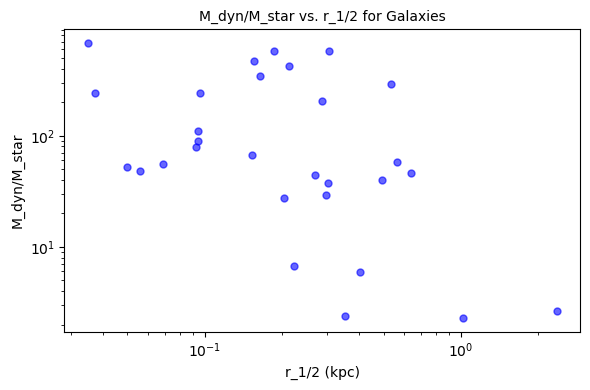

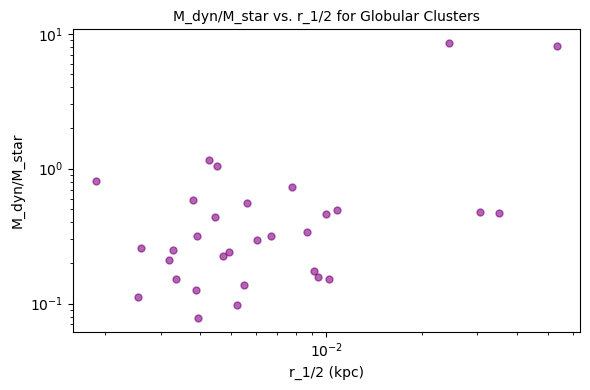

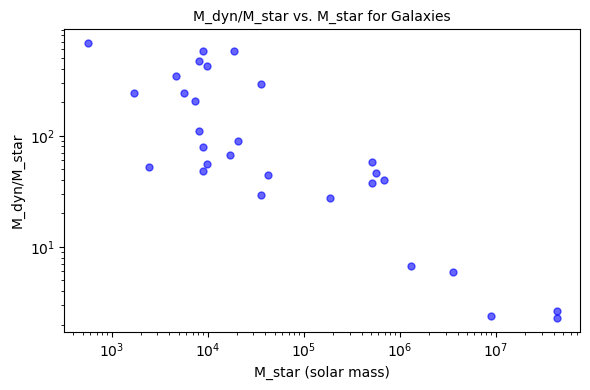

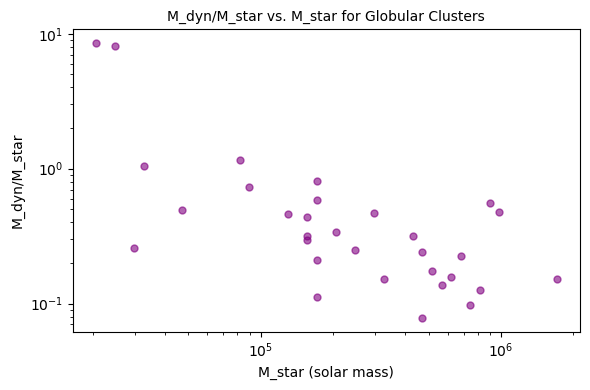

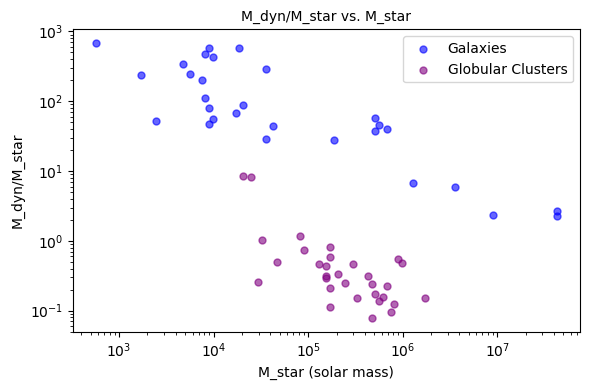

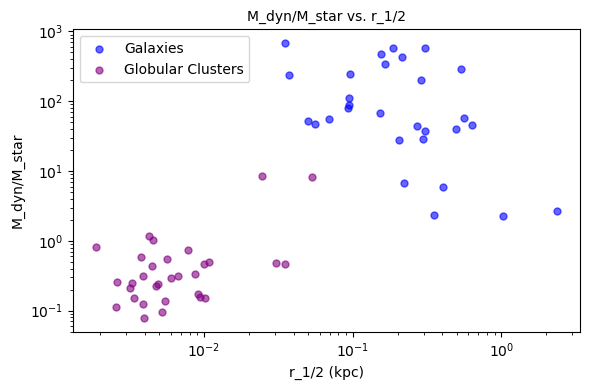

In [130]:
def calculate_mstar(Mv):
    M_star = 2 * 10**(-0.4 * (Mv - 4.83))   # units of solar mass
    return M_star

MV = df_clean.iloc[:, 5].astype(float)
Mstar_g = []
Mstar_gc = []

for i, j in type_galactic_object.items():
    mv = MV.loc[i]
    if j == 'G':
        Mstar_g.append(calculate_mstar(mv))
    elif j == 'GC':
        Mstar_gc.append(calculate_mstar(mv))

ratio_g  = [m_g/m_s for m_g, m_s in zip(M_g,  Mstar_g)]
ratio_gc = [m_g/m_s for m_g, m_s in zip(M_gc, Mstar_gc)]


plt.figure(figsize=(6,4))
plt.scatter(rhalf_g, ratio_g, s=25, marker="o", alpha=0.6, c = "blue")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('r_1/2 (kpc)', fontsize = 10)  
plt.ylabel('M_dyn/M_star', fontsize = 10)  
plt.title('M_dyn/M_star vs. r_1/2 for Galaxies', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()
   

plt.figure(figsize=(6,4))
plt.scatter(rhalf_gc, ratio_gc, s=25, marker="o", alpha=0.6, c = "purple")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('r_1/2 (kpc)', fontsize = 10)  
plt.ylabel('M_dyn/M_star', fontsize = 10)  
plt.title('M_dyn/M_star vs. r_1/2 for Globular Clusters', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(Mstar_g, ratio_g, s=25, marker="o", alpha=0.6, c = "blue")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('M_star (solar mass)', fontsize = 10)  
plt.ylabel('M_dyn/M_star', fontsize = 10)  
plt.title('M_dyn/M_star vs. M_star for Galaxies', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()
   

plt.figure(figsize=(6,4))
plt.scatter(Mstar_gc, ratio_gc, s=25, marker="o", alpha=0.6, c = "purple")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('M_star (solar mass)', fontsize = 10)  
plt.ylabel('M_dyn/M_star', fontsize = 10)  
plt.title('M_dyn/M_star vs. M_star for Globular Clusters', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.show()

# I also want to make some plots where the galaxies and globular clusters are combined

plt.figure(figsize=(6,4))
plt.scatter(Mstar_g, ratio_g, s=25, marker="o", alpha=0.6, c = "blue", label="Galaxies")
plt.scatter(Mstar_gc, ratio_gc, s=25, marker="o", alpha=0.6, c = "purple", label="Globular Clusters")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('M_star (solar mass)', fontsize = 10)  
plt.ylabel('M_dyn/M_star', fontsize = 10)  
plt.title('M_dyn/M_star vs. M_star', fontsize = 10)  
plt.grid(False)  
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.scatter(rhalf_g, ratio_g, s=25, marker="o", alpha=0.6, c = "blue", label="Galaxies")
plt.scatter(rhalf_gc, ratio_gc, s=25, marker="o", alpha=0.6, c = "purple", label="Globular Clusters")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('r_1/2 (kpc)', fontsize = 10)  
plt.ylabel('M_dyn/M_star', fontsize = 10)  
plt.title('M_dyn/M_star vs. r_1/2', fontsize = 10)
plt.legend()  
plt.grid(False)  
plt.tight_layout()
plt.show()



## Problem 4 - Fit a Hernquist profile to the M_dyn vs r_1/2 data for galaxies. What is the best-fitting total mass M and scale radius a? How do these compare to M_dyn(< r_1/2) and r_1/2?

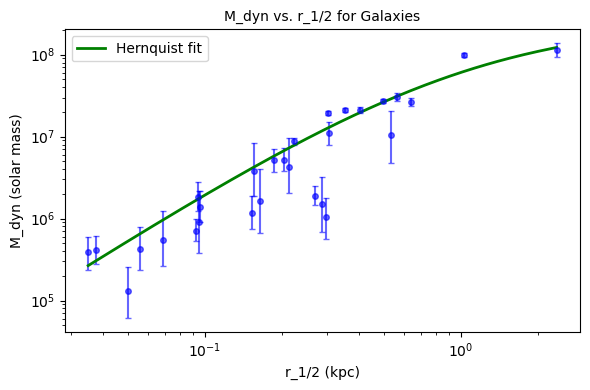

Best fit for total mass: 255379778.74879515
Best fit for a: 1.0501304210306388


In [135]:
def hernquist_profile_fit(r, M, a):
    hernquist = M * (r**2) / (r + a)**2
    return hernquist 


M_g_array = np.array(M_g, dtype=float)
rhalf_g_array = np.array(rhalf_g)
rhalf_space = np.logspace(np.log10(rhalf_g_array.min()), np.log10(rhalf_g_array.max()), 200)
popt, cov = curve_fit(hernquist_profile_fit, rhalf_g_array, M_g_array, p0=[100000000,np.median(rhalf_g_array)])

plt.figure(figsize=(6,4))
#plt.scatter(rhalf_g, M_g_array, s=25, marker="o", alpha=0.6, c = "blue", label="Galaxies")
plt.errorbar(rhalf_g, M_g,
             yerr=np.vstack([errMlow_g, errMhigh_g]),
             fmt="o", ms=4, alpha=0.6, capsize=2, color="blue", ecolor="blue")
plt.plot(rhalf_space, hernquist_profile_fit(rhalf_space, popt[0], popt[1]), color = "green", lw=2, label="Hernquist fit")
plt.xscale("log")
plt.yscale("log")    
plt.xlabel('r_1/2 (kpc)', fontsize = 10)  
plt.ylabel('M_dyn (solar mass)', fontsize = 10)  
plt.title('M_dyn vs. r_1/2 for Galaxies', fontsize = 10)  
plt.grid(False)  
plt.tight_layout()
plt.legend()
plt.show()


print("Best fit for total mass:", popt[0])
print("Best fit for a:", popt[1])

## Problem 5 - Do globular clusters and galaxies always separate out cleanly based on dynamics (that is, is it always possible to say “object X is a galaxy and object Y is a globular cluster” if we just know MV , R_eff , and σ_LOS)? Why or why not (explain your answer)?

Globular clusters and galaxies separate relatively cleanly based on their dynamics as evidenced by the plots above. I would argue that while it is possible to distinguish an object as either a globular cluster or galaxy 